In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import cartopy
import xarray as xa
import scipy.stats

In [2]:
def is_monsoon_precip(month):
    return (month <= 9) & (month >= 6)

data = xa.open_dataarray(
    "/tempest/duan0000/exprecip/cpc-global/NAM_sub_precip")  # CPC
monsoon_precip = data.sel(time=(is_monsoon_precip(data.time.dt.month)))
monsoon_precip = monsoon_precip.sel(time=(monsoon_precip.time.dt.year < 2019))

In [3]:
slp_anomaly = xa.open_dataarray('../Composites/daily_slp_stand_anomaly.nc')
z500_anomaly = xa.open_dataarray('../Composites/daily_z500_stand_anomaly.nc')
ivt_a_anomaly = xa.open_dataarray('../Composites/daily_ivt_a_stand_anomaly.nc')
ivt_b_anomaly = xa.open_dataarray('../Composites/daily_ivt_b_stand_anomaly.nc')
ivt_N_anomaly = xa.open_dataarray('../Composites/daily_ivt_N_stand_anomaly.nc')
ivt_E_anomaly = xa.open_dataarray('../Composites/daily_ivt_E_stand_anomaly.nc')
tcwv_anomaly = xa.open_dataarray('../Composites/daily_tcwv_stand_anomaly.nc')
pv200_anomaly = xa.open_dataarray('../Composites/daily_pv200_stand_anomaly.nc')
q850_anomaly = xa.open_dataarray('../Composites/daily_q850_stand_anomaly.nc')

w500_anomaly = xa.open_dataarray('../Composites/daily_w500_std_anomaly.nc')
cape_anomaly = xa.open_dataarray('../Composites/daily_cape_std_anomaly.nc')

In [4]:
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

def plot_composites(sub_id, time, field, fig, ax, title, rolling=None, vmax=None):
    field_sel = field.sel(time=time)
    mean = field_sel.mean(dim='time')
    std = field_sel.std(dim='time')
    t_statistic = mean/(std/np.sqrt(mean.shape[0]))
    t_flatten = t_statistic.data.reshape(-1)
    crit1 = scipy.stats.norm.ppf(1-0.05/2)
    ind = np.where((t_flatten>-crit1)&(t_flatten<crit1))[0]
    plot_mean = mean.data.copy()
    plot_mean_flatten = plot_mean.reshape(-1)
    plot_mean_flatten[ind]=np.nan
    plot_mean = plot_mean_flatten.reshape(t_statistic.shape)
    if vmax is None:
        vmin = np.nanmin(plot_mean)
        vmax = np.nanmax(plot_mean)
        vmax = np.max([np.abs(vmin), vmax])
    norm = colors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    ax.contourf(mean.longitude, mean.latitude, plot_mean, levels=50, norm=norm, cmap='coolwarm')
    if rolling is None:
        ax.contour(mean.longitude, mean.latitude, t_statistic, levels=[-crit1, crit1], colors='black')
    else:
        t_smooth = t_statistic.rolling(latitude=10, center=True).mean().dropna("latitude")
        t_smooth = t_smooth.rolling(longitude=10, center=True).mean().dropna("longitude")
        ax.contour(t_smooth.longitude, t_smooth.latitude, t_smooth, levels=[-crit1, crit1], colors='black')
    # ax.add_feature(cartopy.feature.STATES)
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
    ax.set_title(title)
    
    fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(sub_id)+".shp"
    shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
    ax.add_feature(shape_feature)

In [5]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
def add_latlon(ax, top, left, bottom, right):
    gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = top
    gl.left_labels = left
    gl.right_labels = right
    gl.bottom_labels=bottom
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator([0, 20, 40, 60])
    gl.xlocator = mticker.FixedLocator([-140, -120, -100, -80])

# Sub5

In [20]:
sub_id = 5
sub_precip = monsoon_precip.sel(sub_id=sub_id)
sub_precip = sub_precip[sub_precip>1]
bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
tutt_sub = np.load(str(sub_id)+'_all_TUTT.npy')
tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')
surge_sub = np.load(str(sub_id)+'_all_surge.npy')
midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
mcs_sub = np.load(str(sub_id)+'_all_MCS.npy')
front_sub = np.load(str(sub_id)+'_all_front.npy')

In [23]:
front_days = np.where(front_sub>0)[0]
front_days = sub_precip.time.data[front_days]
mid_days = np.where(midtro_sub>0)[0]
mid_days = sub_precip.time.data[mid_days]
mid_front_days = list(set(mid_days).intersection(set(front_days)))
print(len(mid_front_days))

43


##  Front

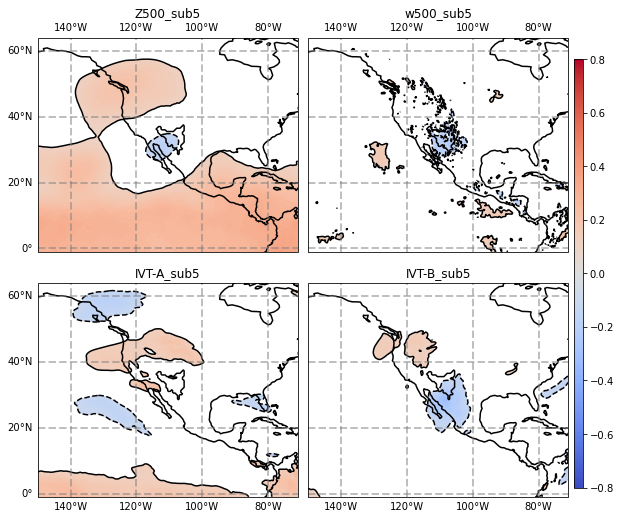

In [8]:
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(221, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=5, time=front_days, field=z500_anomaly, fig=fig, ax=ax, title='Z500_sub5', vmax=0.8)
add_latlon(ax, top=True, left=True, bottom=False, right=False)
ax = fig.add_subplot(222, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=5, time=front_days, field=w500_anomaly, fig=fig, ax=ax, title='w500_sub5', vmax=0.8)
add_latlon(ax, top=True, left=False, bottom=False, right=False)
ax = fig.add_subplot(223, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=5, time=front_days, field=ivt_a_anomaly, fig=fig, ax=ax, title='IVT-A_sub5', vmax=0.8)
add_latlon(ax, top=False, left=True, bottom=True, right=False)
ax = fig.add_subplot(224, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=5, time=front_days, field=ivt_b_anomaly, fig=fig, ax=ax, title='IVT-B_sub5', vmax=0.8)
add_latlon(ax, top=False, left=False, bottom=True, right=False)
vmax = 0.8
norm = colors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)

plt.show()

## Midtro

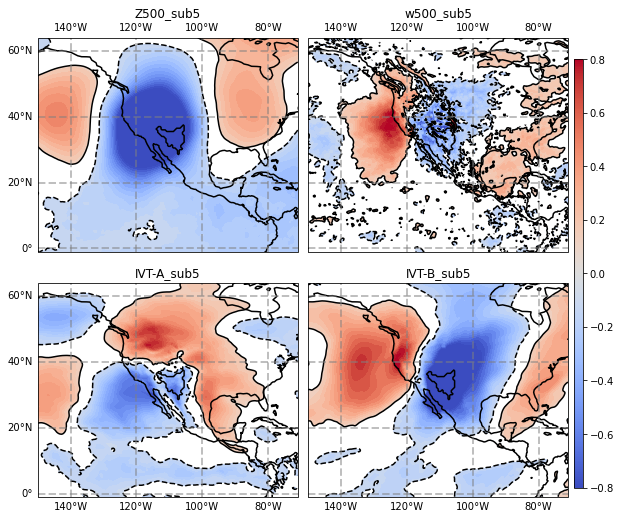

In [10]:
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(221, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=5, time=mid_days, field=z500_anomaly, fig=fig, ax=ax, title='Z500_sub5', vmax=0.8)
add_latlon(ax, top=True, left=True, bottom=False, right=False)
ax = fig.add_subplot(222, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=5, time=mid_days, field=w500_anomaly, fig=fig, ax=ax, title='w500_sub5', vmax=0.8)
add_latlon(ax, top=True, left=False, bottom=False, right=False)
ax = fig.add_subplot(223, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=5, time=mid_days, field=ivt_a_anomaly, fig=fig, ax=ax, title='IVT-A_sub5', vmax=0.8)
add_latlon(ax, top=False, left=True, bottom=True, right=False)
ax = fig.add_subplot(224, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=5, time=mid_days, field=ivt_b_anomaly, fig=fig, ax=ax, title='IVT-B_sub5', vmax=0.8)
add_latlon(ax, top=False, left=False, bottom=True, right=False)
vmax = 0.8
norm = colors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)

plt.show()

## Mid+front

In [11]:
mid_front_days = list(set(mid_days).intersection(set(front_days)))
print(len(mid_front_days))

43


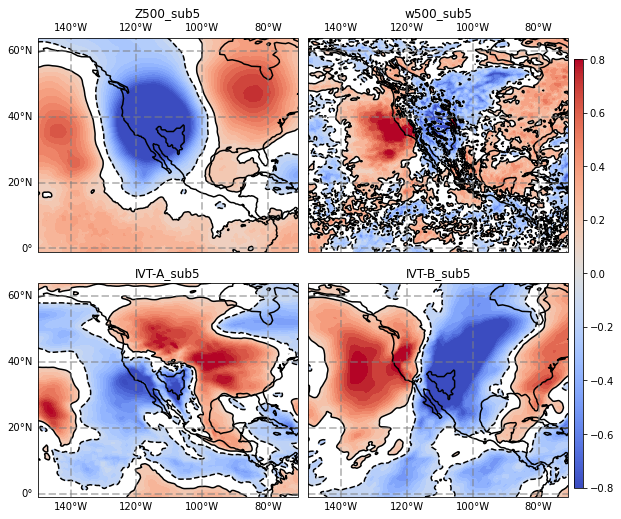

In [12]:
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(221, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=5, time=mid_front_days, field=z500_anomaly, fig=fig, ax=ax, title='Z500_sub5', vmax=0.8)
add_latlon(ax, top=True, left=True, bottom=False, right=False)
ax = fig.add_subplot(222, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=5, time=mid_front_days, field=w500_anomaly, fig=fig, ax=ax, title='w500_sub5', vmax=0.8)
add_latlon(ax, top=True, left=False, bottom=False, right=False)
ax = fig.add_subplot(223, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=5, time=mid_front_days, field=ivt_a_anomaly, fig=fig, ax=ax, title='IVT-A_sub5', vmax=0.8)
add_latlon(ax, top=False, left=True, bottom=True, right=False)
ax = fig.add_subplot(224, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=5, time=mid_front_days, field=ivt_b_anomaly, fig=fig, ax=ax, title='IVT-B_sub5', vmax=0.8)
add_latlon(ax, top=False, left=False, bottom=True, right=False)
vmax = 0.8
norm = colors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)

plt.show()

* Midtro-lows increase uplift, and introduce moisture from GOM. 

## Surge-midtro

In [24]:
surge_days = np.where(surge_sub>0)[0]
surge_days = sub_precip.time.data[surge_days]
surge_midtro_days = list(set(mid_days).intersection(set(surge_days)))
print(len(surge_midtro_days))

87


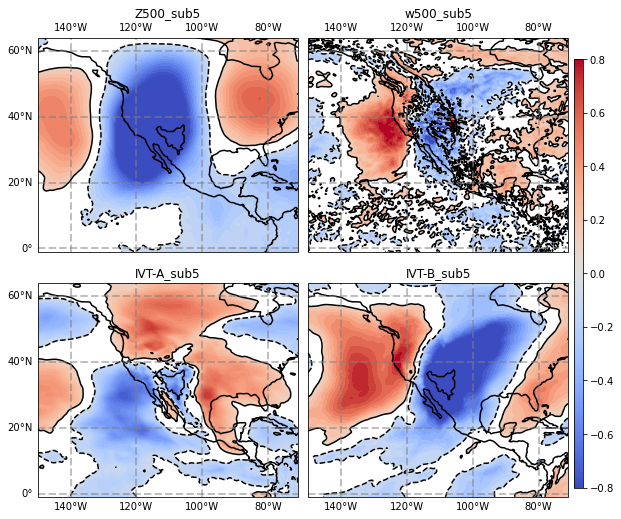

In [25]:
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(221, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=5, time=surge_midtro_days, field=z500_anomaly, fig=fig, ax=ax, title='Z500_sub5', vmax=0.8)
add_latlon(ax, top=True, left=True, bottom=False, right=False)
ax = fig.add_subplot(222, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=5, time=surge_midtro_days, field=w500_anomaly, fig=fig, ax=ax, title='w500_sub5', vmax=0.8)
add_latlon(ax, top=True, left=False, bottom=False, right=False)
ax = fig.add_subplot(223, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=5, time=surge_midtro_days, field=ivt_a_anomaly, fig=fig, ax=ax, title='IVT-A_sub5', vmax=0.8)
add_latlon(ax, top=False, left=True, bottom=True, right=False)
ax = fig.add_subplot(224, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=5, time=surge_midtro_days, field=ivt_b_anomaly, fig=fig, ax=ax, title='IVT-B_sub5', vmax=0.8)
add_latlon(ax, top=False, left=False, bottom=True, right=False)
vmax = 0.8
norm = colors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)

plt.show()

# Sub4

In [13]:
sub_id = 4
sub_precip = monsoon_precip.sel(sub_id=sub_id)
sub_precip = sub_precip[sub_precip>1]
bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
tutt_sub = np.load(str(sub_id)+'_all_TUTT.npy')
tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')
surge_sub = np.load(str(sub_id)+'_all_surge.npy')
midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
mcs_sub = np.load(str(sub_id)+'_all_MCS.npy')
front_sub = np.load(str(sub_id)+'_all_front.npy')

In [14]:
front_days = np.where(front_sub>0)[0]
front_days = sub_precip.time.data[front_days]
mid_days = np.where(midtro_sub>0)[0]
mid_days = sub_precip.time.data[mid_days]
mid_front_days = list(set(mid_days).intersection(set(front_days)))
print(len(mid_front_days))

70


In [18]:
surge_days = np.where(surge_sub>0)[0]
surge_days = sub_precip.time.data[surge_days]
surge_midtro_days = list(set(mid_days).intersection(set(surge_days)))
print(len(surge_midtro_days))

87


## front

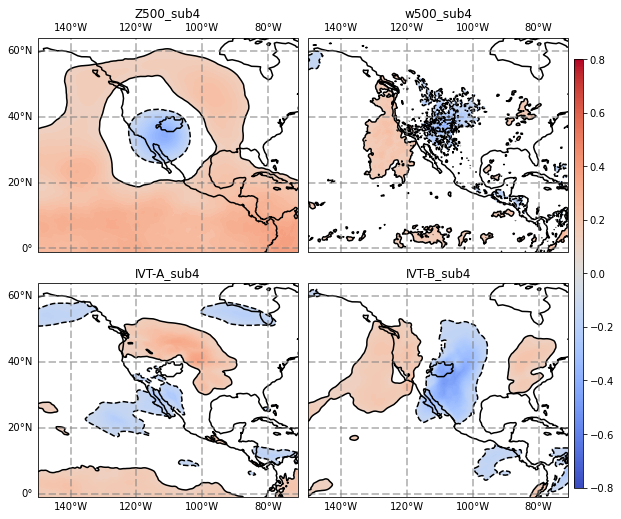

In [15]:
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(221, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=4, time=front_days, field=z500_anomaly, fig=fig, ax=ax, title='Z500_sub4', vmax=0.8)
add_latlon(ax, top=True, left=True, bottom=False, right=False)
ax = fig.add_subplot(222, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=4, time=front_days, field=w500_anomaly, fig=fig, ax=ax, title='w500_sub4', vmax=0.8)
add_latlon(ax, top=True, left=False, bottom=False, right=False)
ax = fig.add_subplot(223, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=4, time=front_days, field=ivt_a_anomaly, fig=fig, ax=ax, title='IVT-A_sub4', vmax=0.8)
add_latlon(ax, top=False, left=True, bottom=True, right=False)
ax = fig.add_subplot(224, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=4, time=front_days, field=ivt_b_anomaly, fig=fig, ax=ax, title='IVT-B_sub4', vmax=0.8)
add_latlon(ax, top=False, left=False, bottom=True, right=False)
vmax = 0.8
norm = colors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)

plt.show()

## midtro

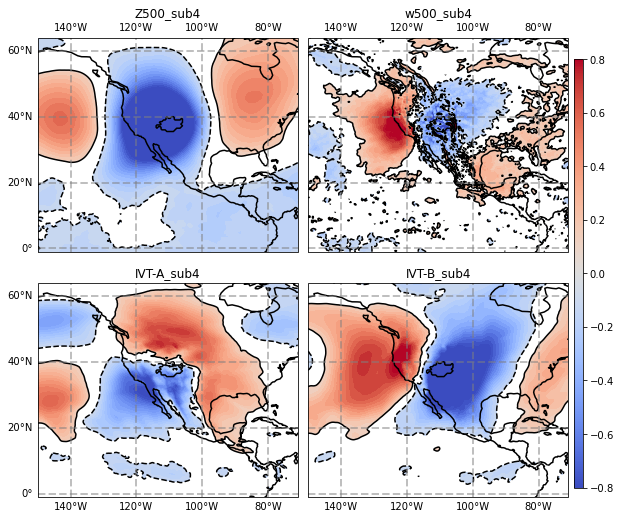

In [16]:
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(221, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=4, time=mid_days, field=z500_anomaly, fig=fig, ax=ax, title='Z500_sub4', vmax=0.8)
add_latlon(ax, top=True, left=True, bottom=False, right=False)
ax = fig.add_subplot(222, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=4, time=mid_days, field=w500_anomaly, fig=fig, ax=ax, title='w500_sub4', vmax=0.8)
add_latlon(ax, top=True, left=False, bottom=False, right=False)
ax = fig.add_subplot(223, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=4, time=mid_days, field=ivt_a_anomaly, fig=fig, ax=ax, title='IVT-A_sub4', vmax=0.8)
add_latlon(ax, top=False, left=True, bottom=True, right=False)
ax = fig.add_subplot(224, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=4, time=mid_days, field=ivt_b_anomaly, fig=fig, ax=ax, title='IVT-B_sub4', vmax=0.8)
add_latlon(ax, top=False, left=False, bottom=True, right=False)
vmax = 0.8
norm = colors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)

plt.show()

## mid+front

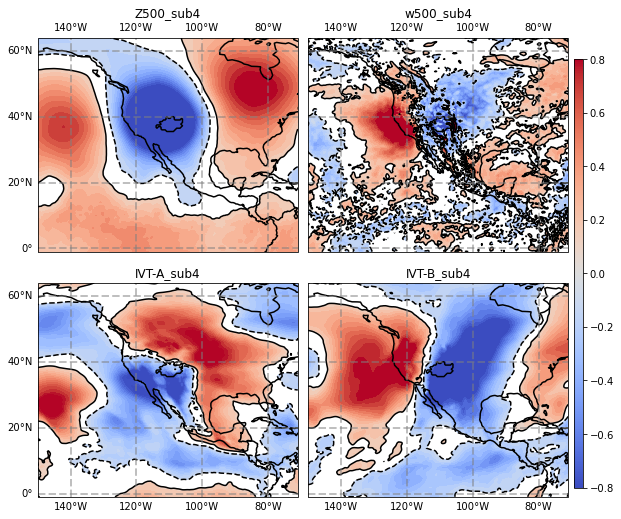

In [17]:
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(221, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=4, time=mid_front_days, field=z500_anomaly, fig=fig, ax=ax, title='Z500_sub4', vmax=0.8)
add_latlon(ax, top=True, left=True, bottom=False, right=False)
ax = fig.add_subplot(222, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=4, time=mid_front_days, field=w500_anomaly, fig=fig, ax=ax, title='w500_sub4', vmax=0.8)
add_latlon(ax, top=True, left=False, bottom=False, right=False)
ax = fig.add_subplot(223, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=4, time=mid_front_days, field=ivt_a_anomaly, fig=fig, ax=ax, title='IVT-A_sub4', vmax=0.8)
add_latlon(ax, top=False, left=True, bottom=True, right=False)
ax = fig.add_subplot(224, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=4, time=mid_front_days, field=ivt_b_anomaly, fig=fig, ax=ax, title='IVT-B_sub4', vmax=0.8)
add_latlon(ax, top=False, left=False, bottom=True, right=False)
vmax = 0.8
norm = colors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)

plt.show()

## Surge+midtro

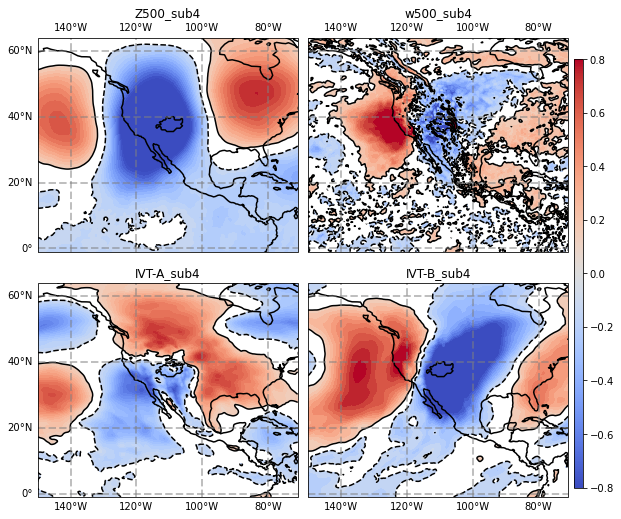

In [19]:
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(221, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=4, time=surge_midtro_days, field=z500_anomaly, fig=fig, ax=ax, title='Z500_sub4', vmax=0.8)
add_latlon(ax, top=True, left=True, bottom=False, right=False)
ax = fig.add_subplot(222, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=4, time=surge_midtro_days, field=w500_anomaly, fig=fig, ax=ax, title='w500_sub4', vmax=0.8)
add_latlon(ax, top=True, left=False, bottom=False, right=False)
ax = fig.add_subplot(223, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=4, time=surge_midtro_days, field=ivt_a_anomaly, fig=fig, ax=ax, title='IVT-A_sub4', vmax=0.8)
add_latlon(ax, top=False, left=True, bottom=True, right=False)
ax = fig.add_subplot(224, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=4, time=surge_midtro_days, field=ivt_b_anomaly, fig=fig, ax=ax, title='IVT-B_sub4', vmax=0.8)
add_latlon(ax, top=False, left=False, bottom=True, right=False)
vmax = 0.8
norm = colors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)

plt.show()